# 🤖 Welcome to the Robot Training Activity!  

In this activity, you'll be teaching a **Thymio robot** to perform movements using **Reinforcement Learning (RL)**.  

---

## **📌 Problem Definition**  
Train an educational robot **Thymio** to:  
✅ Move its motors to mimic **front crawl**.  
✅ Learn **optimal motor actions** for different states.  
✅ Improve **movement accuracy** over time using **Q-learning**.  

### **🎯 Goal**  
The robot should learn to:  
- **Synchronize or dephase its motors** based on its state.  
- Receive **rewards for correct movements** and penalties for mistakes.  
- Use **trial and error** to refine its actions.  

You'll guide the robot through **training, testing, and evaluation**, helping it become smarter with each attempt! 🚀  

# Environment Definition

## 📌 **States**  
The robot has **four states**, representing the phase position of each motor:  
- **(0°, 0°)** → Both motors are in sync  
- **(180°, 0°)** → Right motor is dephased  
- **(0°, 180°)** → Left motor is dephased  
- **(180°, 180°)** → Both motors are dephased  

## 📌 **Actions**  
The robot can take **three actions**:  
1. **Right motor moves 90°**  
3. **Left motor moves 90°**  
4. **Both motors move**  

## 📌 **Rewards**  
The reward function encourages **asynchronous movement** (front crawl behavior) based on the correct motor activation, +1 for correct behavior and -1 for incorrect behavior. 
The correct action for each state:  
- **"R0, L0"** → `[0, 1]` (One motor should move to dephase)  
- **"R0, L180"** → `[2]` (Motors are dephased, both should move together)  
- **"R180, L0"** → `[2]` (Motors are dephased, both should move together)  
- **"R180, L180"** → `[0, 1]` (One motor should move to dephase)

In [4]:
#!pip install tdmclient
#!pip install numpy
#!pip install -U matplotlib

In [5]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node b88b19b6-9d9d-41bd-9dd0-b68e48bd617b

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [7]:
# Variables used in Q-learning
ALPHA = 0.2  # Learning rate
EPSILON = 0.4  # 0.2 Exploration rate 

# To measure performance
accuracies = []

# Define Actions & States
actions = [0, 1, 2]
states = ["R0, L0", "R0, L180", "R180, L0", "R180, L180"]

# Motion variables
motor_speed = 80

detection_threshold = 10

# Two possible table initializations: 0 or random; defined as a dictionary
Q_table = {state: {action: 0 for action in actions} for state in states}  #table as 0
#Q_table = {state: {action: random.randint(0, 1) for action in actions} for state in states} # random table takes longer to converge

#print(Q_table)

In [8]:
def motors(left, right):
    """Allows motor movement. """
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

async def get_sensor_values(sensor_id, delay=0.0008):
    """Reads sensor values after a short delay. Gives exterior sensors (right and left). """
    node = await client.wait_for_node()
    await node.wait_for_variables({sensor_id})
    await client.sleep(delay)  # Allow sensor values to update
    sensor_values = list(node[sensor_id])  # Retrieve the sensor values
    l_sensor = sensor_values[1]
    r_sensor = sensor_values[3]
    bl_sensor = sensor_values[5]
    br_sensor = sensor_values[6]
    return l_sensor, r_sensor, bl_sensor, br_sensor

l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal", delay=0.0008)
print(br_sensor)

0


In [9]:
async def initialize_motors(motor_speed, threshold):
    """ Function to ensure both motors start at the same position """
    print("Initialization")
    # Variables
    # Read the sensor values
    l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")  # Read proximity sensors
        
    # Activate flags because there is a delay when sensed
    l_active, r_active = 0, 0

    # Until both front sensors sense something, the motors will keep running
    while not (l_active and r_active):  # Keep running until both are active
        l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")  # Read proximity sensors
        # print(f"Left: {l_sensor}, Right: {r_sensor}")

        # Check if left sensor is activated
        if l_sensor > threshold:
            l_active = 1
        # Check if right sensor is activated
        if r_sensor > threshold:
            r_active = 1

        # Control motors based on sensor states
        if l_active and r_active:
            node.send_set_variables(motors(0, 0))
            # print("Both motors stopped.")
        elif l_active:
            node.send_set_variables(motors(0, motor_speed))
            # print("Left stopped, Right moving.")
        elif r_active:
            node.send_set_variables(motors(motor_speed, 0))
            # print("Right stopped, Left moving.")
        else:
            node.send_set_variables(motors(motor_speed, motor_speed)) 
            # print("Both moving.")

    node.send_set_variables(motors(0, 0))  # Ensure final stop
    state = "R0, L0"
    return state

# await initialize_motors(motor_speed, detection_threshold)

In [10]:
async def initialization_left(threshold):
    # Read the sensor values
    l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")  # Read proximity sensors
    # Activate flags because there is a delay when sensed
    l_active = 0

    # Until both front sensors sense something, the motors will keep running
    while not l_active:  # Keep running until both are active
        l_sensor, _, bl_sensor, _ = await get_sensor_values("prox.horizontal")  # Read proximity sensors
        # print(f"Left: {l_sensor}, Right: {r_sensor}")

        # Check if left sensor is activated
        if l_sensor > threshold:
            l_active = 1
            node.send_set_variables(motors(0, 0))
        else:
            node.send_set_variables(motors(motor_speed, motor_speed)) 
            # print("Both moving.")

    node.send_set_variables(motors(0, 0))  # Ensure final stop
    
async def determine_180_360(motor_speed, threshold):
    print("Making sure left motor starts at initial position")
    await initialization_left(detection_threshold)
    node.send_set_variables(motors(0, 0)) 
    
    # Start timer
    print("Starting timing")
    start_time = time.time()

    # Clear any lingering sensor values
    l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")
    if l_sensor > threshold:
        # Continue to move until no longer sensed, then repeat and stop until sensed
        while l_sensor > threshold or bl_sensor > threshold:
            # print("Left sensor was active at start, moving until off.")
            l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")
            node.send_set_variables(motors(motor_speed, 0))  

    l_active = False
    bl_active = False
    time_180 = 0
    time_360 = 0
    
    while not l_active: 
        node.send_set_variables(motors(motor_speed, 0)) 
        l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")
        
        # Register 360° rotation time
        if l_sensor > threshold:
            print("Front sensor active")
            l_active = True
            time_360 = time.time()
            
        # Register 180° rotation time ONCE
        if bl_sensor > threshold and not bl_active and not l_active:
            print("Backsensor active")
            bl_active = True
            time_180 = time.time()

    rotation_time = time_360 - start_time
    print(f"\n✅ 360° rotation time: {rotation_time:.2f} seconds")
    half_rotation_duration = time_180 - start_time
    print(f"\n✅ 180° rotation time: {half_rotation_duration:.2f} seconds")
    
    return rotation_time, half_rotation_duration

async def average_rotation_times(motor_speed, threshold, num_trials=3):
    rotation_times = []
    half_rotation_times = []

    for trial in range(num_trials):
        print(f"\n🔄 Running trial {trial + 1}...")
        rotation_time, half_time = await determine_180_360(motor_speed, threshold)
        # Reruns 
        if rotation_time > 10 or rotation_time < 3:
            print("⚠️ Front sensor malfunction. Retrying...")
            rotation_time, half_time = await determine_180_360(motor_speed, threshold)
        if half_time > 5 or half_time < 1:
            print("⚠️ Back sensor malfunction. Retrying...")
            rotation_time, half_time = await determine_180_360(motor_speed, threshold)
        rotation_times.append(rotation_time)
        half_rotation_times.append(half_time)

    avg_time_360 = sum(rotation_times) / num_trials
    avg_time_180 = sum(half_rotation_times) / num_trials
    print(f"\n✅ Average 180° rotation time: {avg_time_180:.2f} seconds")
    print(f"\n✅ Average 360° rotation time: {avg_time_360:.2f} seconds")
    return avg_time_360, avg_time_180

# num_trials = 4
# time_360, time_180 = await average_rotation_times(motor_speed, detection_threshold, num_trials)
# node.send_set_variables(motors(0, 0))

## 🚀 Motor Activation Table

This table describes how the `activate_motors(action, state, time_180)` function controls the motors based on the action input.

| **Action (`action`)** | **Right Motor** | **Left Motor** | **Behavior** |
|-----------------|-------------|------------|------------|
| `0` | ❌ Off | ✅ On (100) | Moves **right** (left motor off) |
| `1` | ✅ On (100) | ❌ Off | Moves **left** (right motor off) |
| `2` | ✅ On (100) | ✅ On (100) | Moves **forward** (both motors on) |

In [12]:
def activate_motors(action, state, time_180):
    """Execute action according to action sent."""
    # states = ["R0, L0", "R0, L180", "R180, L0", "R180, L180"]
    # print((f"Current State: {state}"))
    if action == 0:  # Turn on right motor forward (left off)
        node.send_set_variables(motors(0, motor_speed))
        state_transitions = {
            "R0, L0": "R180, L0",
            "R0, L180": "R180, L180",
            "R180, L0": "R0, L0",
            "R180, L180": "R0, L180"
        }
        next_state = state_transitions[state]
        
    elif action == 1:  # Turn on left motor forward (right off)
        node.send_set_variables(motors(motor_speed, 0))
        state_transitions = {
            "R0, L0": "R0, L180",
            "R0, L180": "R0, L0",
            "R180, L0": "R180, L180",
            "R180, L180": "R180, L0"
        }
        next_state = state_transitions[state]
    elif action == 2:  # Turn on both motors
        node.send_set_variables(motors(motor_speed, motor_speed))
        state_transitions = {
            "R0, L0": "R180, L180",
            "R0, L180": "R180, L0",
            "R180, L0": "R0, L180",
            "R180, L180": "R0, L0"
        }
        next_state = state_transitions[state]

    time.sleep(time_180) # Keep the motor on for the time it takes to do 180°, then turn off
    node.send_set_variables(motors(0, 0))    
    # print((f"Next state according to action: {next_state}"))
    return next_state

In [13]:
def check_correct_time(start_time, stop_time, reference_time):
    # Calculate how long it took from start to stop
    time_elapsed = stop_time - start_time
    # print(f"⏱️ Time elapsed: {time_elapsed:.2f} s (expected: {reference_time:.2f} s)")

    # Define acceptable bounds (±40%)
    lower_bound = 0.70 * reference_time
    upper_bound = 1.3 * reference_time

    # Check if the elapsed time is within range
    if lower_bound <= time_elapsed <= upper_bound:
        return True
    else:
        print(f"❌ Elapsed time {time_elapsed:.2f}s is outside the allowed range ({lower_bound:.2f}s to {upper_bound:.2f}s)")
        return False

async def activate_motors_sensors(action, state, time_360, time_180, threshold):
    # Set initial state
    condition = None  
    start_time = time.time()

    # Set motor command and expected next state based on current state and action
    if action == 0:
        node.send_set_variables(motors(0, motor_speed))  # Move right motor only
        if state == "R0, L0": next_state, condition = "R180, L0", 1
        elif state == "R0, L180": next_state, condition = "R180, L180", 1
        elif state == "R180, L0": next_state, condition = "R0, L0", 2
        elif state == "R180, L180": next_state, condition = "R0, L180", 2
    elif action == 1:
        node.send_set_variables(motors(motor_speed, 0))  # Move left motor only
        if state == "R0, L0": next_state, condition = "R0, L180", 3
        elif state == "R0, L180": next_state, condition = "R0, L0", 4
        elif state == "R180, L0": next_state, condition = "R180, L180", 3
        elif state == "R180, L180": next_state, condition = "R180, L0", 4
    elif action == 2:
        node.send_set_variables(motors(motor_speed, motor_speed))  # Move both motors
        if state == "R0, L0": next_state, condition = "R180, L180", 5
        elif state == "R0, L180": next_state, condition = "R180, L0", 7
        elif state == "R180, L0": next_state, condition = "R0, L180", 8
        elif state == "R180, L180": next_state, condition = "R0, L0", 6

    # --- SINGLE MOTOR CONDITIONS ---
    print(f"Condition: {condition}")
    # Condition 1: Right motor should stop at 180° (back-right sensor)
    if condition == 1:
        print("Keep the right motor running until 360° sensor activates")
        while True:
            l, r, bl, br = await get_sensor_values("prox.horizontal")
            if br > threshold and r < threshold:
                if check_correct_time(start_time, time.time(), time_180):
                    node.send_set_variables(motors(0, 0))
                    break
                else:
                    # Wait until 360° sensor is passed, then restart timer
                    while True:
                        _, r, _, _ = await get_sensor_values("prox.horizontal")
                        if r > threshold:
                            start_time = time.time()
                            break
    # **Condition 2:** Keep the right motor running until 360° sensor activates & time is similar
    elif condition == 2:
        print("Keep the right motor running until 360° sensor activates")
        while True:
            _, r, _, _ = await get_sensor_values("prox.horizontal")
            if r > threshold:
                if check_correct_time(start_time, time.time(), time_360 - time_180):
                    node.send_set_variables(motors(0, 0))
                    break
                else:
                    while True:
                        *_, br = await get_sensor_values("prox.horizontal")
                        if br > threshold:
                            start_time = time.time()
                            break
    # **Condition 3:** Keep the left motor running until 180° sensor activates & time is similar
    elif condition == 3:
        print("Keep the left motor running until 180° sensor activates")
        while True:
            l, r, bl, br = await get_sensor_values("prox.horizontal")
            if bl > threshold and l < threshold:
                if check_correct_time(start_time, time.time(), time_180):
                    node.send_set_variables(motors(0, 0))
                    break
                else:
                    while True:
                        l, *_ = await get_sensor_values("prox.horizontal")
                        if l > threshold:
                            start_time = time.time()
                            break
    # **Condition 4:** Keep the left motor running until 360° sensor activates & time is similar
    elif condition == 4:
        print("Keep the left motor running until 360° sensor activates")
        while True:
            l, *_ = await get_sensor_values("prox.horizontal")
            if l > threshold:
                if check_correct_time(start_time, time.time(), time_360 - time_180):
                    node.send_set_variables(motors(0, 0))
                    break
                else:
                    while True:
                        *_, bl, _ = await get_sensor_values("prox.horizontal")
                        if bl > threshold:
                            start_time = time.time()
                            break

    # --- DUAL MOTOR CONDITIONS ---
    # **Condition 5:** Keep the motors running until both 180° 
    elif condition == 5:
        print("Keep the motors running until both 180°")
        r_done = False
        l_done = False

        while not (r_done and l_done):
            l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")

            if br_sensor > threshold and r_sensor < threshold and not r_done:
                node.send_set_variables(motors(motor_speed, 0))  # Stop right motor
                r_done = True

            if bl_sensor > threshold and l_sensor < threshold and not l_done:
                node.send_set_variables(motors(0, motor_speed))  # Stop left motor
                l_done = True

        node.send_set_variables(motors(0, 0))

    # **Condition 6:** Keep the motors running until both 360° 
    elif condition == 6:
        print("Keep the motors running until both 360°")
        r_done = False
        l_done = False

        while not (r_done and l_done):
            l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")

            if r_sensor > threshold and not r_done:
                node.send_set_variables(motors(motor_speed, 0))  # Stop right motor
                r_done = True

            if l_sensor > threshold and not l_done:
                node.send_set_variables(motors(0, motor_speed))  # Stop left motor
                l_done = True

        node.send_set_variables(motors(0, 0))

    # **Condition 7:** Keep the motors running until 180° right, 360° left & time is similar
    elif condition == 7:
        print("Keep the motors running until 180° right, 360° left")
        r_done = False
        l_done = False

        while not (r_done and l_done):
            l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")

            if br_sensor > threshold and r_sensor < threshold and not r_done:
                node.send_set_variables(motors(motor_speed, 0))  # Stop right motor
                r_done = True

            if l_sensor > threshold and not l_done:
                node.send_set_variables(motors(0, motor_speed))  # Stop left motor
                l_done = True

        node.send_set_variables(motors(0, 0))

    # **Condition 8:** Keep the motors running until 360° right, 180° left & time is similar
    elif condition == 8:
        print("Keep the motors running until 360° right, 180° left")
        r_done = False
        l_done = False

        while not (r_done and l_done):
            l_sensor, r_sensor, bl_sensor, br_sensor = await get_sensor_values("prox.horizontal")

            if r_sensor > threshold and not r_done:
                node.send_set_variables(motors(motor_speed, 0))  # Stop right motor
                r_done = True

            if bl_sensor > threshold and l_sensor < threshold and not l_done:
                node.send_set_variables(motors(0, motor_speed))  # Stop left motor
                l_done = True
   
        node.send_set_variables(motors(0, 0))
    return next_state

### 🎯 Reward Function Table

| **State**   | **Valid Actions**  | **Motor moved**  | **Reward Given** |
|------------|------------------|-----------------|----------------|
| `"R0, L0"`  | `[0, 1]`         | `0` (Move Right)  | `+1 ✅` |
| `"R0, L0"`  | `[0, 1]`         | `1` (Move Left)   | `+1 ✅` |
| `"R0, L0"`  | `[0, 1]`         | `2` (Move Both)   | `-1 ❌` |
| `"R0, L180"` | `[2]`           | `2` (Move Both)   | `+1 ✅` |
| `"R0, L180"` | `[2]`           | `0` (Move Right)  | `-1 ❌` |
| `"R0, L180"` | `[2]`           | `1` (Move Left)  | `-1 ❌` |
| `"R180, L0"` | `[2]`           | `2` (Move Both)   | `+1 ✅` |
| `"R180, L0"` | `[2]`           | `1` (Move Left)   | `-1 ❌` |
| `"R180, L0"` | `[2]`           | `0` (Move Right)   | `-1 ❌` |
| `"R180, L180"` | `[0, 1]`       | `0` (Move Right)  | `+1 ✅` |
| `"R180, L180"` | `[0, 1]`       | `1` (Move Left)   | `+1 ✅` |
| `"R180, L180"` | `[0, 1]`       | `2` (Move Both)   | `-1 ❌` |

In [15]:
def get_reward(state, action):
    """ Reward function: returns +1 if the chosen action is in the list of correct actions, else -1. Behavior should be front crawl (asynch)"""
    correct_association = {
        "R0, L0": [0, 1],      # One of the motors should activate so that they are dephased, 0 turns right, 1 turns left
        "R0, L180": [2],       # They are correctly dephased so they should keep moving together
        "R180, L0": [2],       # They are correctly dephased so they should keep moving together
        "R180, L180": [0, 1]   # One of the motors should activate so that they are dephased, 0 turns right, 1 turns left
    }
    
    # If the chosen action is in the correct list, return +1; otherwise, return -1
    return 1 if action in correct_association[state] else -1

In [16]:
async def get_buttons(delay=0.001):
    """Reads button values after a short delay."""
    node = await client.wait_for_node()
    await node.wait_for_variables({"button.forward", "button.backward"})
    forward_button = node.var["button.forward"][0]  
    backward_button = node.var["button.backward"][0]  
    # print(f"Forward: {forward_button}, Backward: {backward_button}") 
    await client.sleep(delay)  # Allow sensor values to update
    return forward_button, backward_button

forward_button, backward_button = await get_buttons()

In [56]:
async def get_reward_child(state, action):
    """Wait for button input and return reward based on correct actions."""
    global mistake_counter

    correct_association = {
        "R0, L0": [0, 1],      # One motor should activate to dephase
        "R0, L180": [2],       # Motors are dephased, should move together
        "R180, L0": [2],       # Motors are dephased, should move together
        "R180, L180": [0, 1]   # One motor should activate to dephase
    }

    # Turn on LED before waiting for input & get actual correct reward
    if action in correct_association[state]:
        node.send_set_variables({"leds.top": [0, 32, 0]})  # Green LED ON (Correct action expected)
        correct_reward = 1
    else:
        node.send_set_variables({"leds.top": [32, 0, 0]})  # Red LED ON (Incorrect action expected)
        correct_reward = -1


    # **Wait until a button is pressed**
    while True:
        forward_button, backward_button = await get_buttons()
        if forward_button == 1:  # Forward button pressed
            reward = 1
            if reward != correct_reward :
                is_correct = False
                mistake_counter += 1
                print("❌")
            else:
                is_correct = True
                print("✅")
            break
        elif backward_button == 1:  # Backward button pressed
            reward = -1
            if reward != correct_reward :
                is_correct = False
                mistake_counter += 1
                print("❌")
            else:
                is_correct = True
                print("✅")
            break
        await client.sleep(0.2)  # Small delay to avoid busy-waiting

    # **Turn off all LEDs after button press**
    node.send_set_variables({"leds.top": [0, 0, 0], "leds.bottom.left": [0, 0, 0]})

    return reward, is_correct

SyntaxError: name 'mistake_counter' is parameter and global (2513183810.py, line 3)

## 🎯 Epsilon-Greedy Action Selection

The `select_action(state)` function implements an **epsilon-greedy policy** for choosing actions in a reinforcement learning setting.

### 🔹 How It Works:
1. **Exploration (`ε` chance):**  
   - With probability `ε`, the agent picks a **random action** (exploration).  
   - This helps the agent try new actions instead of always picking the best-known action.  
   
2. **Exploitation (`1 - ε` chance):**  
   - The agent chooses the **best known action** based on the **highest Q-value** in `Q_table[state]`.  
   - If multiple actions have the same highest Q-value, it picks **randomly among them** to prevent bias.

### 🔹 Function Breakdown:
- The function first decides whether to explore or exploit using a **random integer check**.
- If exploring, it picks a **random action** from `actions`.
- If exploiting, it finds the **highest Q-value** for the given `state` and selects the best action.
- If multiple actions have the same Q-value, it picks randomly among them.

### 🔹 Why Use This?
- Balances **exploration** (finding new strategies) and **exploitation** (using known best actions).
- Ensures the agent does not get **stuck in suboptimal policies**.

In [19]:
def select_action(state):
    """ Epsilon-greedy policy for action selection."""
    if random.randint(0, 10) < EPSILON * 10:  # Scaled for integer compatibility
        print("I'm exploring")
        return random.choice(actions)  # Exploration action, if the agent explores, it picks a random action.
    else:
        max_value = max(Q_table[state].values())
        best_actions = [a for a in actions if Q_table[state][a] == max_value]
        return random.choice(best_actions) # Exploitation action, if it exploits, it picks the best-known action for a given state.

## 🔄 Q-Learning Update Rule

The `update_q_table(state, action, reward, next_state)` function updates the **Q-table** using the **Q-learning formula**.

### 🔹 How It Works:
1. The agent observes:
   - **Current state** ($s$)
   - **Action taken** ($a$)
   - **Reward received** ($r$)
   - **Next state** ($s'$) after taking the action

2. It finds the **best next action**:
   - Looks at all possible actions in **next state** ($s'$).
   - Picks the action with the **highest Q-value** ($\max Q(s', a')$).

3. **Applies the Q-learning update formula**:

   $$
   Q(s, a) = Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
   $$

   Where:
   - **$\alpha$ (ALPHA)** → Learning rate (controls how much new info overrides old knowledge).
   - **$\gamma$ (GAMMA)** → Discount factor (importance of future rewards).
   - **$r$** → Immediate reward received.
   - **$\max Q(s', a')$** → The highest Q-value in the next state ($s'$).

4. **Scales down** the update by dividing by `10` to prevent large jumps in learning.

### 🔹 Why Use This?
- Helps the agent **learn the best long-term strategy**.
- Updates the Q-table based on **rewards**.
- Over time, the agent **converges to the optimal policy**. 

In [21]:
def update_q_table(state, action, reward, next_state, GAMMA):
    """ Q-learning update rule. """
    best_next_action = max(Q_table[next_state], key=Q_table[next_state].get)
    best_next_q = Q_table[next_state][best_next_action]
    current_q = Q_table[state][action]

    # Q-learning update
    updated_q = current_q + ALPHA * (reward + GAMMA * best_next_q - current_q)
    Q_table[state][action] = updated_q

    # Debug prints
    # print(f"Best Next Action: {best_next_action}")
    print(f"State: {state} | Action: {action} | Reward: {reward} | Next State: {next_state}")
    # print(f"Q[{state}][{action}] updated from {current_q:.3f} to {updated_q:.3f}")
    print(f"  → Q(s,a) = {current_q:.3f} + ALPHA {ALPHA} * (reward {reward} + GAMMA {GAMMA} * max_next_q {best_next_q:.3f} - current_q {current_q:.3f})")
    print("Current Q-table:")
    for s in Q_table:
        print(f"  {s}: {Q_table[s]}")

In [22]:
def get_state(initial, next_state):
    """Read motor positions to determine state. Based on activation of 1 sensor. """
    # states = ["R0, L0", "R0, L180", "R180, L0", "R180, L180"]
    if initial:
        print("I'm at the starting position")
        state = "R0, L0"
    else:
        state = next_state
    return state

In [23]:
def det_next_state(action, state):
    # Set motor command and expected next state based on current state and action
    if action == 0:
        if state == "R0, L0": next_state = "R180, L0"
        elif state == "R0, L180": next_state = "R180, L180"
        elif state == "R180, L0": next_state = "R0, L0"
        elif state == "R180, L180": next_state = "R0, L180"
    elif action == 1:
        if state == "R0, L0": next_state = "R0, L180"
        elif state == "R0, L180": next_state = "R0, L0"
        elif state == "R180, L0": next_state = "R180, L180"
        elif state == "R180, L180": next_state = "R180, L0"
    elif action == 2:
        if state == "R0, L0": next_state = "R180, L180"
        elif state == "R0, L180": next_state = "R180, L0"
        elif state == "R180, L0": next_state = "R0, L180"
        elif state == "R180, L180": next_state = "R0, L0"

    return next_state

In [58]:
# Training to get the reward when it does the correct action
def pre_training(n_episodes): 
    """Train the Q-learning agent using state-action-reward-state (SARS) updates."""
    # Go to 0,0 initially to guarantee knowing the next states
    initial = True
    next_state = "R0, L180" # Set it to something initially, can be anything
    GAMMA = 0.9
    
    # Q-learning SARS: state-action-reward-state 
    for episode in range(n_episodes):  # Number of training episodes
        # STATE
        state = get_state(initial, next_state)  # Get current state
        initial = False
        print((f"State: {state}"))
        # ACTION
        action = select_action(state)
        print((f"Action: {action}"))
        # Next state is observed after action is taken because there are no sensors, based on finite state machine
        next_state = det_next_state(action, state) # Get the next_state based on action
        print((f"Next State: {next_state}"))
        # REWARD
        reward = get_reward(state, action)  # Get reward
        # UPDATE Q-TABLE
        update_q_table(state, action, reward, next_state, GAMMA)  # Update Q-table

        # Test accuracy every 10 episodes
        if episode % 3 == 0:
            correct_predictions = sum(
                max(Q_table[s], key=Q_table[s].get) in {"R0, L0": [0,1], "R0, L180": [2], "R180, L0": [2], "R180, L180": [0,1]}[s]
                for s in states
            )
            accuracy = (correct_predictions / len(states)) * 100
            accuracies.append((episode, accuracy))
            print(f"Episode {episode}: Accuracy = {accuracy:.2f}%")

In [60]:
# Training to get the reward when it does the correct action
async def training(n_episodes, time_360, time_180, threshold, mistake_counter): 
    """Train the Q-learning agent using state-action-reward-state (SARS) updates."""
    # Go to 0,0 initially to guarantee knowing the next states
    state = await initialize_motors(motor_speed, threshold)
    initial = True
    next_state = "R0, L180" # Set it to something initially, can be anything
    
    # Q-learning SARS: state-action-reward-state 
    for episode in range(n_episodes):  # Number of training episodes
        # STATE
        state = get_state(initial, next_state)  # Get current state
        initial = False
        # print((f"State: {state}"))
        
        # ACTION
        action = select_action(state)  # Choose an action based on greedy based policy
        # print(f"Action: {action}")
        
        # Next state is observed after action is taken because there are no sensors, based on finite state machine
        next_state = await activate_motors_sensors(action, state, time_360, time_180, detection_threshold) # Do the action associated with that state
        # print(f"Next State: {next_state}")
        
        # REWARD
        reward, is_correct = await get_reward_child(state, action)

        # Discount Factor changes depending on moment in training (Further training carries more weight)
        gamma_correct = 0.9
        gamma_wrong_start = 0.5
        gamma_wrong = gamma_wrong_start + (gamma_correct - gamma_wrong_start) * (episode / (n_episodes - 1))
        GAMMA = gamma_correct if is_correct else gamma_wrong
        print(f"Gamma: {GAMMA}")
        # print(f"Reward: {reward}")
        
        update_q_table(state, action, reward, next_state, GAMMA)  # Update Q-table

        # Test accuracy every 10 episodes
        if episode % 3 == 0:
            correct_predictions = sum(
                max(Q_table[s], key=Q_table[s].get) in {"R0, L0": [0,1], "R0, L180": [2], "R180, L0": [2], "R180, L180": [0,1]}[s]
                for s in states
            )
            accuracy = (correct_predictions / len(states)) * 100
            accuracies.append((episode, accuracy))
            print(f"Episode {episode}: Accuracy = {accuracy:.2f}%")

In [62]:
def plot_training_accuracy(): 
    episodes, accuracy_values = zip(*accuracies)
    
    plt.figure(figsize=(8, 5))
    plt.plot(episodes, accuracy_values, marker='o', linestyle='-', color='b')
    plt.xlabel("Training Episodes")
    plt.ylabel("Accuracy (%)")
    plt.title("Q-learning Accuracy Improvement Over Training")
    plt.ylim(0, 110)  # Accuracy should be between 0 and 100%
    plt.grid(True)
    plt.show()

In [64]:
async def testing_over_time(time_360, time_180, num_movements=10):
    """ Tests the learned policy over an extended period (at least 10 movements). """
    # Start from a known initial state
    state = await initialize_motors(motor_speed, detection_threshold)  
    print(f"\n🔄 Starting at Initial State: {state}")
    
    correct_predictions = 0
    
    for move in range(num_movements):  # Loop through at least 20 movements
        action = select_action(state)  # Choose action based on learned policy
        
        # Expected correct actions
        correct_actions = {"R0, L0": [0, 1], "R0, L180": [2], "R180, L0": [2], "R180, L180": [0, 1]}
        correct_action = correct_actions[state]  # Get expected action(s)

        # Ensure correct_action is always a list
        if not isinstance(correct_action, list):
            correct_action = [correct_action]

        # Execute action and determine new state
        next_state = await activate_motors_sensors(action, state, time_360, time_180, detection_threshold)  
        print(f"🔁 Movement {move+1}: {state} → {next_state} via Action {action}")

        # Check if the action was correct
        if action in correct_action:
            correct_predictions += 1

        # Update state for the next movement
        state = next_state

    # Compute and print accuracy over extended movements
    accuracy = (correct_predictions / num_movements) * 100
    print(f"\n✅ Final Accuracy Over {num_movements} Movements: {correct_predictions}/{num_movements} correct ({accuracy:.2f}%)")

# 🚀 Testing Q-learning Performance Before and After Training

## **🔹 Overview**
This section evaluates how well the Thymio robot has **learned to perform correct movements** using Q-learning.  
We will:
1. **Initialize the Q-table** (untrained, all values set to zero).  
2. **Measure the time required for a 180° turn and 360°** (`average_rotation_times()`).  
3. **Test the initial policy before training** (`testing_w_sensing()`).  
4. **Train the robot using reinforcement learning** (`training(n_episodes)`).  
5. **Test the learned policy after training** to see improvements in accuracy.  
6. **Compare results before and after training** to evaluate learning effectiveness.

## **🎯 Expected Results**
| **Phase**     | **Behavior** |
|--------------|-------------|
| **Before Training** | The robot moves **randomly**, making many mistakes. Accuracy is **low**. |
| **After Training**  | The robot **chooses better actions**, leading to **higher accuracy**. |

### **Initial Policy Testing**  

In [72]:
# Initialize Q-table with zeros
Q_table = {state: {action: 0 for action in actions} for state in states}
accuracies = []
print("Initial Q_table:", Q_table)

Initial Q_table: {'R0, L0': {0: 0, 1: 0, 2: 0}, 'R0, L180': {0: 0, 1: 0, 2: 0}, 'R180, L0': {0: 0, 1: 0, 2: 0}, 'R180, L180': {0: 0, 1: 0, 2: 0}}


In [31]:
# Measure the time required for a 180° rotation
num_trials = 3
time_360, time_180 = await average_rotation_times(motor_speed, detection_threshold, num_trials)
await initialize_motors(motor_speed, detection_threshold)

node.send_set_variables(motors(0, 0))


🔄 Running trial 1...
Making sure left motor starts at initial position
Starting timing
Backsensor active
Front sensor active

✅ 360° rotation time: 5.14 seconds

✅ 180° rotation time: 2.85 seconds

🔄 Running trial 2...
Making sure left motor starts at initial position
Starting timing
Backsensor active
Front sensor active

✅ 360° rotation time: 4.94 seconds

✅ 180° rotation time: 2.49 seconds

🔄 Running trial 3...
Making sure left motor starts at initial position
Starting timing
Backsensor active
Front sensor active

✅ 360° rotation time: 4.51 seconds

✅ 180° rotation time: 2.04 seconds

✅ Average 180° rotation time: 2.46 seconds

✅ Average 360° rotation time: 4.86 seconds
Initialization


In [ ]:
# Test initial policy before training (expected to have low accuracy)
# await testing_w_sensing(time_180)
await testing_over_time(time_360, time_180, num_movements=10)

### **Training**  

I'm at the starting position
State: R0, L0
Action: 1
Next State: R0, L180
State: R0, L0 | Action: 1 | Reward: 1 | Next State: R0, L180
  → Q(s,a) = 0.000 + ALPHA 0.2 * (reward 1 + GAMMA 0.9 * max_next_q 0.000 - current_q 0.000)
Current Q-table:
  R0, L0: {0: 0, 1: 0.2, 2: 0}
  R0, L180: {0: 0, 1: 0, 2: 0}
  R180, L0: {0: 0, 1: 0, 2: 0}
  R180, L180: {0: 0, 1: 0, 2: 0}
Episode 0: Accuracy = 50.00%
State: R0, L180
I'm exploring
Action: 1
Next State: R0, L0
State: R0, L180 | Action: 1 | Reward: -1 | Next State: R0, L0
  → Q(s,a) = 0.000 + ALPHA 0.2 * (reward -1 + GAMMA 0.9 * max_next_q 0.200 - current_q 0.000)
Current Q-table:
  R0, L0: {0: 0, 1: 0.2, 2: 0}
  R0, L180: {0: 0, 1: -0.164, 2: 0}
  R180, L0: {0: 0, 1: 0, 2: 0}
  R180, L180: {0: 0, 1: 0, 2: 0}
State: R0, L0
I'm exploring
Action: 1
Next State: R0, L180
State: R0, L0 | Action: 1 | Reward: 1 | Next State: R0, L180
  → Q(s,a) = 0.200 + ALPHA 0.2 * (reward 1 + GAMMA 0.9 * max_next_q 0.000 - current_q 0.200)
Current Q-table:
  R0, L

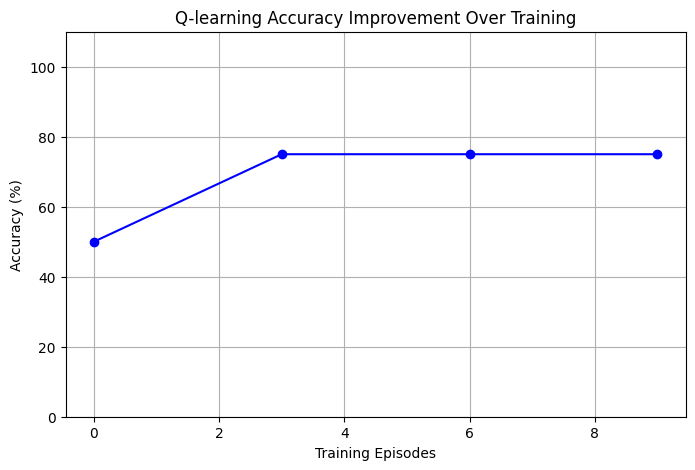

In [60]:
# Pretraining
pre_training_iter = 10
pre_training(pre_training_iter)
plot_training_accuracy()

Initialization
I'm at the starting position
I'm exploring
Condition: 3
Keep the left motor running until 180° sensor activates
❌
Gamma: 0.5
State: R0, L0 | Action: 1 | Reward: -1 | Next State: R0, L180
  → Q(s,a) = 0.000 + ALPHA 0.2 * (reward -1 + GAMMA 0.5 * max_next_q 0.000 - current_q 0.000)
Current Q-table:
  R0, L0: {0: 0, 1: -0.2, 2: 0}
  R0, L180: {0: 0, 1: 0, 2: 0}
  R180, L0: {0: 0, 1: 0, 2: 0}
  R180, L180: {0: 0, 1: 0, 2: 0}
Episode 0: Accuracy = 50.00%
I'm exploring
Condition: 4
Keep the left motor running until 360° sensor activates
✅
Gamma: 0.9
State: R0, L180 | Action: 1 | Reward: -1 | Next State: R0, L0
  → Q(s,a) = 0.000 + ALPHA 0.2 * (reward -1 + GAMMA 0.9 * max_next_q 0.000 - current_q 0.000)
Current Q-table:
  R0, L0: {0: 0, 1: -0.2, 2: 0}
  R0, L180: {0: 0, 1: -0.2, 2: 0}
  R180, L0: {0: 0, 1: 0, 2: 0}
  R180, L180: {0: 0, 1: 0, 2: 0}
I'm exploring
Condition: 5
Keep the motors running until both 180°
✅
Gamma: 0.9
State: R0, L0 | Action: 2 | Reward: -1 | Next State:

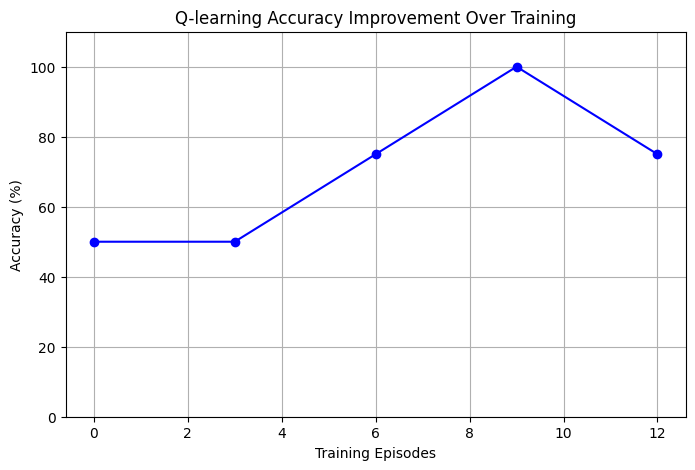

In [74]:
EPSILON = 0.8  # Explore a lot to compensate being pretrained
training_iter = 15
accuracies = []  # Reset before starting a new training run
mistake_counter = 0
await training(training_iter, time_360, time_180, detection_threshold, mistake_counter)
print(f"Total button feedback mistakes: {mistake_counter}")
plot_training_accuracy()

### **Testing after training**  

In [64]:
print("final Q_table", Q_table)

# await testing_w_sensing(time_180)
EPSILON = 0.0  # Do not explore
await testing_over_time(time_360, time_180, num_movements=10)

final Q_table {'R0, L0': {0: 0, 1: 0.21039999999999998, 2: 0}, 'R0, L180': {0: -0.331472, 1: -0.26639999999999997, 2: 0.535664}, 'R180, L0': {0: 0, 1: -0.2827168, 2: 0.26480000000000004}, 'R180, L180': {0: 0.26935111111111104, 1: 0, 2: 0.237872}}
Initialization

🔄 Starting at Initial State: R0, L0
Condition: 3
Keep the left motor running until 180° sensor activates
🔁 Movement 1: R0, L0 → R0, L180 via Action 1
Condition: 7
Keep the motors running until 180° right, 360° left
🔁 Movement 2: R0, L180 → R180, L0 via Action 2
Condition: 8
Keep the motors running until 360° right, 180° left
🔁 Movement 3: R180, L0 → R0, L180 via Action 2
Condition: 7
Keep the motors running until 180° right, 360° left
🔁 Movement 4: R0, L180 → R180, L0 via Action 2
Condition: 8
Keep the motors running until 360° right, 180° left
🔁 Movement 5: R180, L0 → R0, L180 via Action 2
Condition: 7
Keep the motors running until 180° right, 360° left
🔁 Movement 6: R0, L180 → R180, L0 via Action 2
Condition: 8
Keep the motor

In [80]:
node.send_set_variables(motors(0, 0))

In [76]:
await node.unlock()